# **FantaBayesianNet: a Bayesian Network to make inference on individual performance in football**

***Fundamentals of Artificial Intelligence and Knowledge Representation (Mod. 3) - Alma Mater Studiorum Università di Bologna***

*Authors:*
- Giuseppe	Boezio	(0001005271 $-$ giuseppe.boezio@studio.unibo.it)
- Giuseppe	Murro	(0000997317 $-$ giuseppe.murro@studio.unibo.it)
- Salvatore	Pisciotta	(0000985203 $-$ salvatore.pisciotta2@studio.unibo.it)

## **Abstract**
This notebook explains the work done and the results achieved in the Knowledge Representation class project,
specifically in the module about uncertainty and probabilistic reasoning, held by professor Paolo Torroni.

The task of predicting the performance of football players is gaining increasing
attention in the sports and statistical communities. In this work, we used a Bayesian Network to model relevant factors of player performance in the
presence of noisy data. We apply our analysis to the 2020–2021 season in the top Italian league, Serie A, and use the player ratings provided by a popular Italian fantasy football game, the so-called *Fantacalcio*.

Our central goals are to explore what are the causal relations that allow to predict if a football player can be deployed or not in a fantasy football lineup. Different kind of reasoning are done to exploit the flows of influence between variables and possible independences.

In [ ]:
import sys
!{sys.executable} -m pip install pgmpy

     |████████████████████████████████| 337kB 11.3MB/s 


In [ ]:
import time
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer

%matplotlib inline

from pgmpy.estimators import BayesianEstimator
from pgmpy.models import BayesianModel
from pgmpy.inference import VariableElimination
import networkx as nx

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## **1. Data preprocessing**
The first step consists in load data, merge different dataframes to get a single dataframe of players and process feature in order to work with them.

Since statistics of single football players of Serie A in each mach are not directly accessible and they are distributed on different web sites, we have developed a *web scraping script* (accessible from the [repository](https://github.com/giuseppeboezio/FantaBayesianNet/blob/main/src/ScrapingPlayer.py)) able to collect data from [*Fantacalcio.it*](https://www.fantacalcio.it/statistiche-serie-a) and [*Transfermarket.it*](https://www.transfermarkt.it/serie-a/startseite/wettbewerb/IT1). 

We decided to select only **forwards**, since their statistics are the most interesting from the view point of the *Fantacalcio*, and we picked an average of 2 players per team for a total of 40 players. 

These data are about the first 30 rounds of the 2020–2021 Serie A season.

In [ ]:
!git clone https://github.com/giuseppeboezio/FantaBayesianNet.git

Cloning into 'FantaBayesianNet'...
remote: Enumerating objects: 324, done.
remote: Counting objects: 100% (324/324), done.
remote: Compressing objects: 100% (183/183), done.
remote: Total 324 (delta 188), reused 267 (delta 135), pack-reused 0
Receiving objects: 100% (324/324), 2.84 MiB | 6.86 MiB/s, done.
Resolving deltas: 100% (188/188), done.


In [ ]:
data_dir= "FantaBayesianNet/data" 

In [ ]:
list_files = sorted(
    [
        os.path.join(data_dir, fname)
        for fname in os.listdir(data_dir)
        if fname.endswith(".csv")
    ]
)


players = []

for file in list_files:
  players.append(pd.read_csv(file))

df = pd.concat(players)
df

,matchday,date,home_team_pos,home_team,away_team_pos,away_team,result,available,goal,assist,autogoal,yellow_card,double_yellow_card,red_card,substitution_on,substitution_off,minutes,penalty_kicker,home_match,score,grade,penalty_scored,penalty_kick,starter,postponed,difficulty_match,deployability
0,3,02/ott/2020,9.0,Fiorentina,18.0,Sampdoria,1:2,non convocato,0,0,0,False,False,False,NaN,NaN,0,False,False,NaN,NaN,0,0,False,False,3,False
1,4,17/ott/2020,14.0,Sampdoria,9.0,Lazio,3:0,Available,0,0,0,False,False,False,79.0,NaN,11,False,True,NaN,NaN,0,0,False,False,3,False
2,5,24/ott/2020,4.0,Atalanta,9.0,Sampdoria,1:3,Available,0,1,0,True,False,False,66.0,NaN,24,False,False,6.5,6.0,0,0,False,False,4,False
3,6,01/nov/2020,7.0,Sampdoria,17.0,Genoa,1:1,Available,0,0,0,False,False,False,66.0,NaN,24,False,True,6.5,6.5,0,0,False,False,2,False
4,7,07/nov/2020,12.0,Cagliari,9.0,Sampdoria,2:0,Problema muscolare,0,0,0,False,False,False,NaN,NaN,0,False,False,NaN,NaN,0,0,False,False,2,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24,26,07/mar/2021,20.0,Crotone,17.0,Torino,4:2,Available,0,0,0,False,False,False,NaN,65.0,65,False,False,4.0,4.0,0,0,True,False,3,False
25,27,14/mar/2021,17.0,Torino,1.0,Inter,1:2,Available,0,0,0,False,False,False,67.0,NaN,23,False,True,6.0,6.0,0,0,False,False,5,False
26,28,21/mar/2021,11.0,Sampdoria,17.0,Torino,1:0,Available,0,0,0,False,False,False,59.0,NaN,31,False,False,6.0,6.0,0,0,False,False,4,False
27,29,03/apr/2021,17.0,Torino,3.0,Juventus,2:2,Available,0,0,0,False,False,False,72.0,NaN,18,False,True,6.0,6.0,0,0,False,False,5,False


In the *raw dataset* we have a lot of data, but only some of them are useful for our model.
So in the following cell we have to do:
- **data cleaning** from useless columns and rows that refers to `postponed` matches
- **data discretization** since pgmpy does not support learning from continuous variable, and so all numerical values are mapped into bins
- transform *NaN values* from the `score` into the category "sv", which is more meaningful from the Fantacalcio viewpoint

<br>

The meaning and the values that each **variable** selected from the database can assume is the following:
<ul>
    <li><b>goal</b> = Goal: represents whether, at the correspondent matchday, the player has made a goal and obtained the correspondent bonus(+3)</li>
        <ul>
            <li>True: the player has scored at least one goal</li>
            <li>False: The player didn't even score one goal</li>
        </ul>
    <li><b>assist</b> = Assist: represents whether, at the correspondent matchday, the player has made an assist and obtained the correspondent bonus(+3)</li>
        <ul>
            <li>True: The player has made at least one assist</li>
            <li>False: The player didn't even make one assist</li>
        </ul>
    <li><b>time_range</b> = Range of minutes: minutes played by the player in the correspondent matchday(min=0 minutes, max=90 minutes) </li>
        <ul>
            <li>0-15: The player played no more than 15 minutes</li>
            <li>16-45: The player has played more than 15 minutes but less than 45 minutes</li>
            <li>46-90: The player has played more than 45 minutes</li>
        </ul>
    <li><b>score_range</b> = Range of "fantasy score": fantasy score obtained by the player at the correspondent matchday, with appropriate bonus and malus included </li>
        <ul>
            <li>s.v.: The player has not played or has played too little time to have a vote</li>
            <li><=5: the player had a bad game with some possibile malus </li>
            <li>5.5-6.5: the player did not play a great game or at most a sufficient game </li>
            <li>7-9.5: the player played a great game and may have taken some bonuses as well </li>
            <li>>=10: the player played an excellent game and also took some bonuses </li>
        </ul>
        <li><b>difficulty_match</b> = Difficulty of the match calculated in crescent order through a formula</li>
        <ul>
            <li>1: easy match generally played at home</li>
            <li>2: easy match generally played away</li>
            <li>3: balanced match </li>
            <li>4: difficult match generally played at home</li>
            <li>5: difficult match generally played away </li>
        </ul>
        <li><b>penalty_kicker</b>= Kicker of the team for penalties: represents whether the player (if at the correspondent matchday was avaiable) is the one designed to kick the penalties</li>
        <ul>
            <li>True: The player is the penalty kicker</li>
            <li>False:The player isn't the penalty kicker</li>
        </ul>
        <li><b>home_match</b> = : represents whether, at the correspondent matchday, the player's team played at home or away </li>
        <ul>
            <li>True: the team played the match at home</li>
            <li>False: the team played the match away from home</li>
        </ul>
        <li><b>yellow_card</b> = Admonition: represents whether, at the correspondent matchday, the player the player got a yellow card with correspondent malus(-0.5) </li>
        <ul>
            <li>True: the player received a yellow card</li>
            <li>False: the player didn't receive a yellow card</li>
        </ul>
        <li><b>red_card</b> = Expulsion: represents whether, at the correspondent matchday, the player the player got a red card with correspondent malus(-1) </li>
        <ul>
            <li>True: the player received a red card</li>
            <li>False: the player didn't receive a red card</li>
        </ul>
        <li><b>avaiable</b> = Availability: represent whether the player at the corresponding matchday was available for his team or not (e.g. for an injury or a 
disqualification)</li>
        <ul>
            <li>True: the player was avaiable</li>
            <li>False: the player wasn't avaiable</li>
        </ul>
        <li><b>deployability</b> = Deployability: represents whether the player for the corresponding matchday will be a good choice for the fantasy team of the fantasy manager</li>
        <ul>
            <li>True: deploy the player is a good choice</li>
            <li>False: it is better, if possible, not to deploy the player</li>
        </ul>

</br>











In [ ]:
# remove postponed matches
df.drop(df[df['postponed'] == True].index, inplace=True)

# change available in True/False
df['available'] = df['available'].apply(lambda x : True if x == 'Available' else False)

# change goal in True/False
df['goal'] = df['goal'].apply(lambda x: True if x > 0 else False)

# change assist in True/False
df['assist'] = df['assist'].apply(lambda x: True if x > 0 else False)

# change minutes into ranges [0-15], [16-45], [46-90]
bins = [0, 16, 46, 95]
labels = ['0-15', '16-45', '46-90']
df['time_range'] = pd.cut(df['minutes'], bins=bins, labels=labels, right=False)

# change scores into sv, '<=5', '5.5-6.5', '7-9.5', '>=10'
df['score'].fillna(value=-5, inplace=True)
bins = [-5, -4, 5.5, 7, 10, 25]
labels = ['sv', '<=5', '5.5-6.5', '7-9.5', '>=10']
df['score_range'] = pd.cut(df['score'],  bins=bins, labels=labels, right=False)

# only columns needed
variables = ['penalty_kicker', 'goal', 'assist', 'yellow_card', 'red_card', 'available', 'starter', 'time_range', 'score_range', 'difficulty_match', 'deployability','home_match']
df = df[variables]
df

,penalty_kicker,goal,assist,yellow_card,red_card,available,starter,time_range,score_range,difficulty_match,deployability,home_match
3,False,False,False,False,False,True,False,16-45,5.5-6.5,2,False,True
4,False,False,False,False,False,False,False,0-15,sv,2,False,False
5,False,False,False,False,False,False,False,0-15,sv,2,False,True
6,False,False,False,False,False,False,False,0-15,sv,2,False,False
7,False,False,False,False,False,False,False,0-15,sv,4,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
22,False,False,False,False,False,True,True,46-90,<=5,3,False,False
24,False,False,False,False,False,True,True,46-90,<=5,3,False,False
25,False,False,False,False,False,True,False,16-45,5.5-6.5,5,False,True
26,False,False,False,False,False,True,False,16-45,5.5-6.5,4,False,False


In [ ]:
df.dtypes

penalty_kicker          bool
goal                    bool
assist                  bool
yellow_card             bool
red_card                bool
available               bool
starter                 bool
time_range          category
score_range         category
difficulty_match       int64
deployability           bool
home_match              bool
dtype: object

Correlation matrix has been used to understand whether flow of influence among variables were meaningful.

In [ ]:
# Transforming ordinal variables in order to investigate about them

ordinal_features =['time_range', 'score_range']
ordinal_transformer = OrdinalEncoder(dtype = np.int32)
preprocessor = ColumnTransformer(
    transformers = [
                    ('ord', ordinal_transformer, ordinal_features)
                   ],
                    remainder = 'passthrough'  # with 'passthrough' the non-specified columns in transformers will be automatically passed through                       
    )

preprocessor.fit(df)

df_p = preprocessor.fit_transform(df)
columns= ['time_range', 'score_range', 'penalty_kicker', 'goal', 'assist', 'yellow_card', 'red_card', 'available', 'starter', 'difficulty_match', 'deployability','home_match']

# Conversion on dataframe for all players
df_p = pd.DataFrame(df_p, columns=columns).convert_dtypes()

# Checking types
print(df_p.dtypes)

time_range            Int64
score_range           Int64
penalty_kicker      boolean
goal                boolean
assist              boolean
yellow_card         boolean
red_card            boolean
available           boolean
starter             boolean
difficulty_match      Int64
deployability       boolean
home_match          boolean
dtype: object


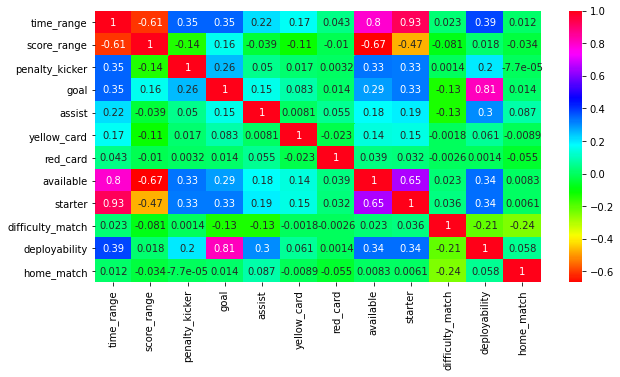

In [ ]:
plt.figure(figsize=(10,5))
sns.heatmap(df_p.corr(), annot=True, cmap='hsv')
plt.show()

Show histograms for all varibles in the dataset to understand their distribution

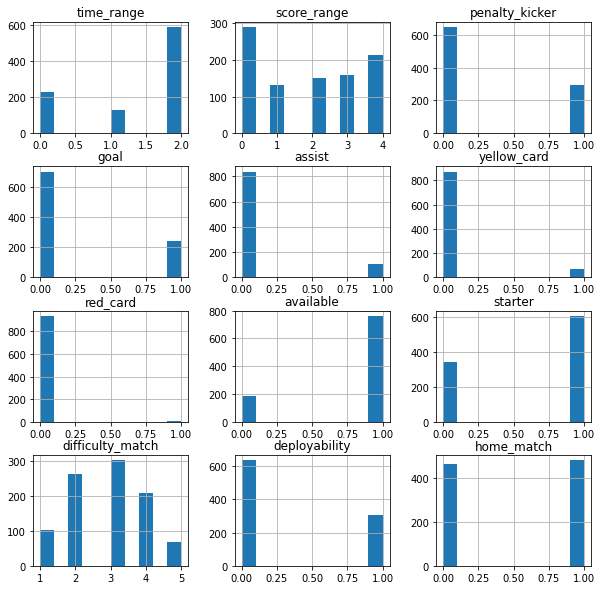

In [ ]:
pd.DataFrame.hist(df_p.astype('int')
                  , figsize = [10,10]
                 );

## **2. Define the model**
The second step consists in building the structure of our model, that is to define the relations between the involved variables.
In the following lines we define the network model using pgmpy library and then we display the resulting graph using networkx.

In [ ]:
model = BayesianModel([('available', 'starter'),
                       ('starter', 'time_range'),
                       ('time_range', 'red_card'),
                       ('time_range', 'yellow_card'),
                       ('time_range', 'goal'),
                       ('time_range', 'assist'),
                       ('available', 'penalty_kicker'),
                       ('penalty_kicker', 'goal'),
                       ('red_card', 'score_range'),
                       ('yellow_card', 'score_range'),
                       ('goal', 'score_range'),
                       ('assist', 'score_range'),
                       ('difficulty_match', 'deployability'),
                       ('score_range', 'deployability'),
                       ('home_match','difficulty_match')
                       ])

#Network nodes and out-edges
nodes = list(model.nodes())
edges = list(model.edges())
print("Nodes:", nodes)
print("\nOutEdges:", edges)

Nodes: ['available', 'starter', 'time_range', 'red_card', 'yellow_card', 'goal', 'assist', 'penalty_kicker', 'score_range', 'difficulty_match', 'deployability', 'home_match']

OutEdges: [('available', 'starter'), ('available', 'penalty_kicker'), ('starter', 'time_range'), ('time_range', 'red_card'), ('time_range', 'yellow_card'), ('time_range', 'goal'), ('time_range', 'assist'), ('red_card', 'score_range'), ('yellow_card', 'score_range'), ('goal', 'score_range'), ('assist', 'score_range'), ('penalty_kicker', 'goal'), ('score_range', 'deployability'), ('difficulty_match', 'deployability'), ('home_match', 'difficulty_match')]


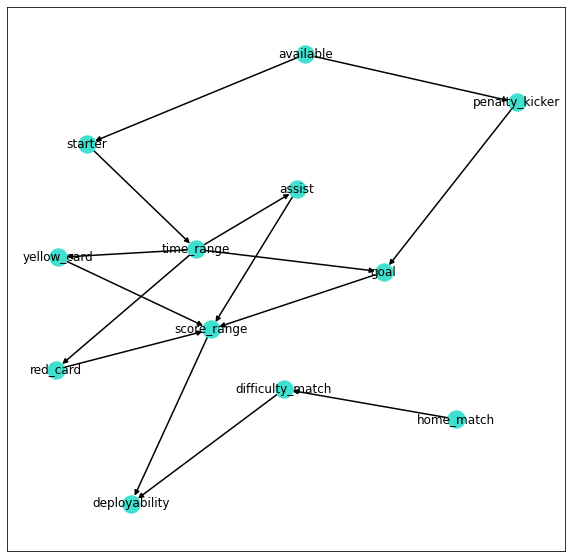

In [ ]:
np.random.seed(34)

DAG = nx.DiGraph()
DAG.add_edges_from(edges)

fig = plt.figure(figsize = (10,10))
pos = nx.spring_layout(DAG) #Position nodes computed by using Fruchterman-Reingold force-directed algorithm.
nx.draw_networkx_nodes(DAG, pos=pos, node_color='turquoise')
nx.draw_networkx_labels(DAG, pos=pos)
nx.draw_networkx_edges(DAG, pos=pos, edge_color='black', width = 1.5, arrows=True)
plt.show()

## **3. Learning of network parameters**
In pgmpy it is possible to **learn the CPT** of a given Bayesian network using either a Bayesian Estimator or a Maximum Likelihood Estimator (MLE). The former exploits a known prior distribution of data, the latter does not make any particular assumption.

The *MLE* can overfit the data in case of small datasets, because there can be not enough observations and thus the observed frequencies can be not representative. Another problem with MLE is the fact that state counts are done conditionally for each parents configuration and this causes immense fragmentation since the state counts drop even more. 

The *Bayesian Estimator* instead does not only rely on input data to learn the network parameters, but it also takes advantage of a prior knowledge, expressed through a prior distribution. In this way, the estimator does not have an absolute guide, but rather a reasonable starting assumption that allows to counterbalance the lack of data.

Although the MLE approach seems plausible, it can be overly simplistic in many cases, whereas the Bayesian one is intrinsically more robust. As a consequence the Bayesian Estimator is choosen.

There are several prior distribuitions available in pgmpy, a sensible choice of prior is the Bayesian Dirichlet equivalent uniform prior (BDeu). In the learning process, using BDeu, N uniform samples are generated for each variable to compute the pseudo-counts (default is N=5), hence the estimated probabilities in CPT are more conservative than the ones obtained through MLE (i.e. probabilities close to 1 or 0 get smoothed).

In the following cell the CPT are learned and displayed.

In [ ]:
from IPython.core.display import display, HTML

# disable text wrapping in output cell
display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))

model.cpds = []
model.fit(  data=df
          , estimator=BayesianEstimator
          , prior_type="BDeu"
          , equivalent_sample_size=10
          ,complete_samples_only=False)

print(f'Check model: {model.check_model()}\n')
for cpd in model.get_cpds():
    print(f'CPT of {cpd.variable}:')
    print(cpd, '\n')


Check model: True

CPT of available:
+------------------+----------+
| available(False) | 0.196017 |
+------------------+----------+
| available(True)  | 0.803983 |
+------------------+----------+ 

CPT of starter:
+----------------+----------------------+---------------------+
| available      | available(False)     | available(True)     |
+----------------+----------------------+---------------------+
| starter(False) | 0.9866310160427807   | 0.20795306388526727 |
+----------------+----------------------+---------------------+
| starter(True)  | 0.013368983957219251 | 0.7920469361147328  |
+----------------+----------------------+---------------------+ 

CPT of time_range:
+-------------------+----------------------+----------------------+
| starter           | starter(False)       | starter(True)        |
+-------------------+----------------------+----------------------+
| time_range(0-15)  | 0.6676356589147286   | 0.00273224043715847  |
+-------------------+----------------------+

## **4. Network Analysis**

Pgmpy allows to easily investigate the properties of the network, indeed it is possible to individuate flows of probabilistic influence, active trials, check the conditionals independence relations between features of the Bayesian network and moreover. In the following cells it is possible to notice these characteristics:
- **Markov blanket**
- **reasoning patterns** and **active trails**
- **indipendences**

### **4.1 Markov blanket**
The **Markov blanket** of a given node consists in the set of parents, children, and children's parents of the node. Moreover, given the Markov blanket of a node, the node itself becomes independent from any other nodes of the network.
The following cell display, for each variable, the node (turquoise) with its Markov blanket (yellow) and the remaining nodes (gray).

-------------------------------------------------------------------------------- 

available 
Markov blanket -> ['penalty_kicker', 'starter']


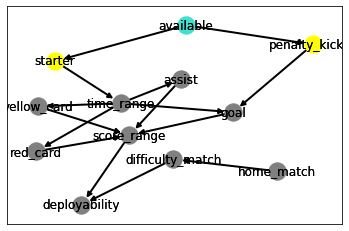

-------------------------------------------------------------------------------- 

starter 
Markov blanket -> ['time_range', 'available']


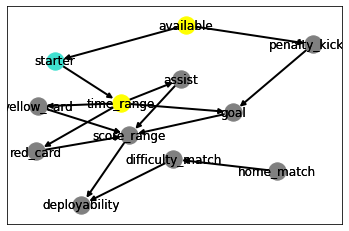

-------------------------------------------------------------------------------- 

time_range 
Markov blanket -> ['penalty_kicker', 'yellow_card', 'goal', 'assist', 'red_card', 'starter']


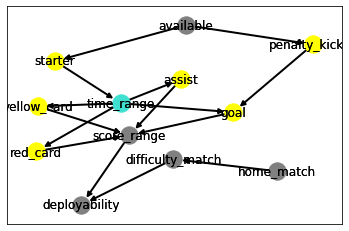

-------------------------------------------------------------------------------- 

red_card 
Markov blanket -> ['yellow_card', 'score_range', 'goal', 'assist', 'time_range']


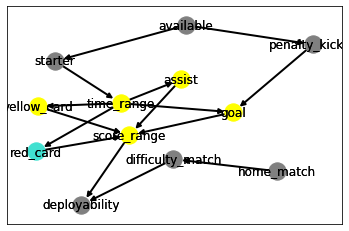

-------------------------------------------------------------------------------- 

yellow_card 
Markov blanket -> ['score_range', 'goal', 'assist', 'red_card', 'time_range']


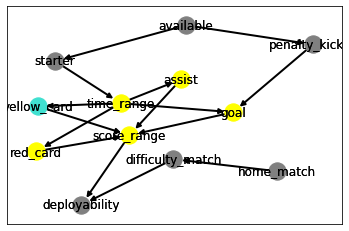

-------------------------------------------------------------------------------- 

goal 
Markov blanket -> ['penalty_kicker', 'yellow_card', 'score_range', 'assist', 'red_card', 'time_range']


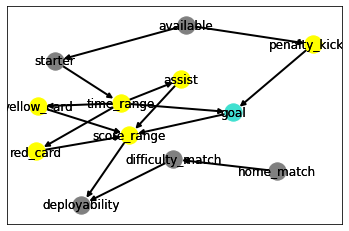

-------------------------------------------------------------------------------- 

assist 
Markov blanket -> ['yellow_card', 'score_range', 'goal', 'red_card', 'time_range']


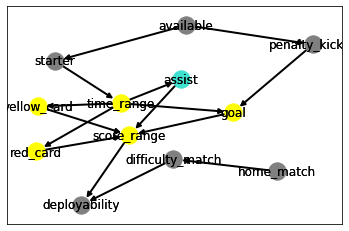

-------------------------------------------------------------------------------- 

penalty_kicker 
Markov blanket -> ['goal', 'time_range', 'available']


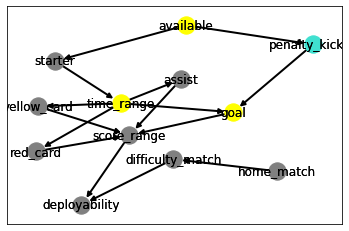

-------------------------------------------------------------------------------- 

score_range 
Markov blanket -> ['yellow_card', 'difficulty_match', 'goal', 'assist', 'red_card', 'deployability']


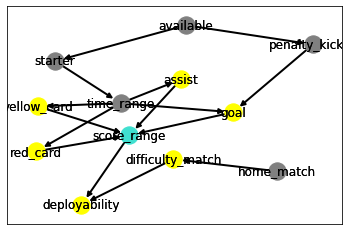

-------------------------------------------------------------------------------- 

difficulty_match 
Markov blanket -> ['home_match', 'deployability', 'score_range']


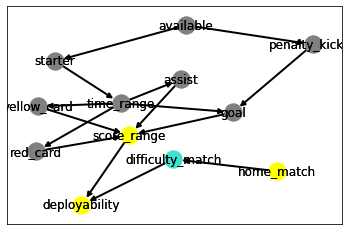

-------------------------------------------------------------------------------- 

home_match 
Markov blanket -> ['difficulty_match']


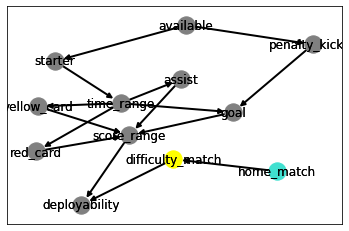

In [ ]:
leaves = model.get_leaves()
markov_blanket = {}

for node in nodes:
    if not node in leaves:
        markov_blanket[node] = model.get_markov_blanket(node)
        print("-"*80,"\n")
        print(node, "\nMarkov blanket ->", markov_blanket[node])
        
        nx.draw_networkx_nodes(DAG, pos, nodelist=[node], node_color='turquoise')
        nx.draw_networkx_nodes(DAG, pos, nodelist=markov_blanket[node], node_color='yellow')
        nx.draw_networkx_nodes(DAG, pos, 
               nodelist = [n for n in nodes if n not in markov_blanket[node] and n != node], 
               node_color='grey')
        nx.draw_networkx_labels(DAG, pos)
        nx.draw_networkx_labels(DAG, pos)
        nx.draw_networkx_edges(DAG, pos, edge_color='black', width = 2.0, arrows=True)
        plt.show()

### **4.2 Reasoning patterns, active trails and d-separation**

The **d-separation principle** allows us to determine whether a set X of variables is independent of another set Y, given a third set Z.
The main idea is to associate dependence with connectedness, and independence with separation. 

Therefore, the d-separation is strictly related to the concept of **active-trail** in a directed graph: if there is no active trail between two variables X and Y, then X and Y are d-separated. Instead if influence can flow from X to Y via Z, the trial X⇌Z⇌Y is active.

In [ ]:
def show_active_trail(model, start, end, evidences={}, trail_to_show=[]):

  title_inference = "P({} | {})".format(end, evidences)

  # prepare figure
  fig = plt.figure(figsize=(13,5))
  ax1, ax2 = fig.subplots(nrows=1, ncols=2)

  # compute query
  inference = VariableElimination(model)
  query = inference.query(variables=[end]
                        , evidence=evidences
                        ,show_progress=False
                        )
  
  probabilities = ["{:.4}%".format(value) for value in query.values]
  table = np.column_stack((query.state_names[query.variables[0]], probabilities))

  # plot inference 
  font_size=14
  bbox=[0, 0, 1, 0.60]
  mpl_table = ax1.table(cellText = table
                      , bbox=bbox
                      , cellLoc='center'
                      , colLabels=query.variables+[ "P({})".format(end)]
                      , colWidths=[1.5, 2]
                      , loc = 'center'
                      , colColours=['#d9d9d9','#d9d9d9'])
  mpl_table.auto_set_font_size(False)
  mpl_table.set_fontsize(font_size)
  ax1.axis('off')
  ax1.set_title(title_inference)
  
  # check if there is an active trail
  active = model.is_active_trail(start=start, end=end, observed=list(evidences.keys()))
  title_graph = "ACTIVE TRAIL ({} -> {}): {}".format(start, end, active)

  edges = list(model.in_edges(trail_to_show))
  trail_edges = edges.copy() 

  # remove unuseful edge
  edges = list(model.in_edges(trail_to_show))
  trail_edges = edges.copy()

  for edge in edges:
    if not all(node in trail_to_show for node in edge):
      trail_edges.remove(edge)

  # plot graph 
  nx.draw_networkx_edges(DAG, pos, edge_color='gray', width = 2.0, arrows=True, ax=ax2)
  nx.draw_networkx_nodes(DAG, pos, nodelist = nodes, node_color='white', edgecolors='grey', ax=ax2)
  nx.draw_networkx_edges(DAG, pos, edgelist=trail_edges, edge_color='black', width = 2.0, arrows=True, ax=ax2)
  nx.draw_networkx_nodes(DAG, pos, nodelist=[start, end], node_color='red',  edgecolors='grey', ax=ax2)
  nx.draw_networkx_nodes(DAG, pos, nodelist=list(evidences.keys()), node_color='yellow', edgecolors='grey', ax=ax2)
  nx.draw_networkx_labels(DAG, pos, ax=ax2)
  
  ax2.set_title(title_graph) 

  plt.show()



CAUSAL REASONING


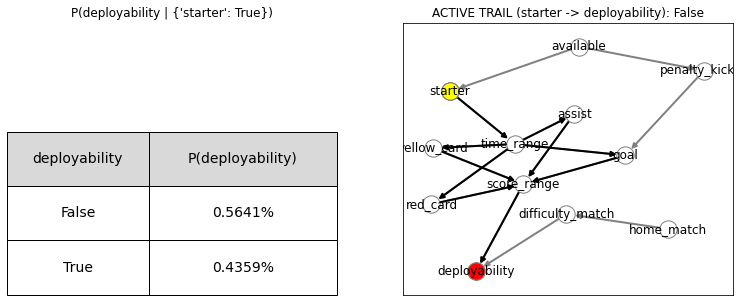

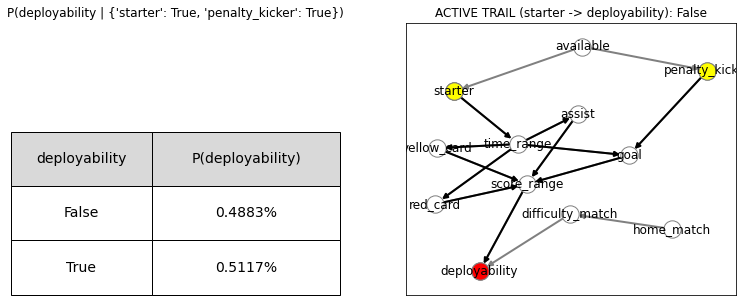

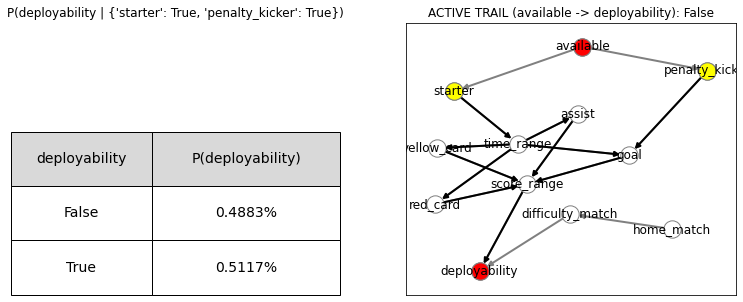


 P(deployability|starter=True,penalty_kicker=True,home_match=True)
+----------------------+----------------------+
| deployability        |   phi(deployability) |
+======================+======================+
| deployability(False) |               0.4777 |
+----------------------+----------------------+
| deployability(True)  |               0.5223 |
+----------------------+----------------------+

 P(deployability|starter=True,penalty_kicker=True,home_match=False)
+----------------------+----------------------+
| deployability        |   phi(deployability) |
+======================+======================+
| deployability(False) |               0.4993 |
+----------------------+----------------------+
| deployability(True)  |               0.5007 |
+----------------------+----------------------+


In [ ]:
# Causal reasoning
print("\n\nCAUSAL REASONING")

show_active_trail(model
                  , start='starter'
                  , end='deployability'
                  , evidences={'starter': True}
                  , trail_to_show=['starter', 'goal', 'red_card', 'yellow_card', 'assist', 'time_range','score_range', 'deployability'])


show_active_trail(model
                  , start='starter'
                  , end='deployability'
                  , evidences={'starter': True,'penalty_kicker':True}
                  , trail_to_show=['starter','penalty_kicker', 'goal', 'red_card', 'yellow_card', 'assist', 'time_range','score_range', 'deployability'])


#Active trail broken by penalty_kicker and starter with respect to available
show_active_trail(model
                  , start='available'
                  , end='deployability'
                  , evidences={'starter':True,'penalty_kicker': True}
                  , trail_to_show=['penalty_kicker','starter', 'goal', 'red_card', 'yellow_card', 'assist', 'time_range','score_range', 'deployability'])

#We can see that we prefer to insert in our starter team a player that plays a match at home and he is a starter and penalty kicker for his team.

In [ ]:
print("\n P(deployability|starter=True,penalty_kicker=True,home_match=True)")
print(inference.query(['deployability']
                      ,{'starter': True,'penalty_kicker':True,'home_match':True}
                      ,show_progress=False
                      ))


print("\n P(deployability|starter=True,penalty_kicker=True,home_match=False)")
print(inference.query(['deployability']
                      ,{'starter': True,'penalty_kicker':True,'home_match':False}
                      ,show_progress=False
                      ))

In [ ]:
#Evidential reasoning
print("\n P(time_range|score_range='5.5-6.5')")
print(inference.query(['time_range']
                      ,{'score_range': '5.5-6.5'}
                      ,show_progress=False
                      ))

print("\n P(time_range|score_range='>=10')")
print(inference.query(['time_range']
                      ,{'score_range': '>=10'}
                      ,show_progress=False
                      ))



 P(time_range|score_range='5.5-6.5')
+-------------------+-------------------+
| time_range        |   phi(time_range) |
+===================+===================+
| time_range(0-15)  |            0.3213 |
+-------------------+-------------------+
| time_range(16-45) |            0.1508 |
+-------------------+-------------------+
| time_range(46-90) |            0.5278 |
+-------------------+-------------------+

 P(time_range|score_range='>=10')
+-------------------+-------------------+
| time_range        |   phi(time_range) |
+===================+===================+
| time_range(0-15)  |            0.0225 |
+-------------------+-------------------+
| time_range(16-45) |            0.1020 |
+-------------------+-------------------+
| time_range(46-90) |            0.8755 |
+-------------------+-------------------+


In [ ]:
# TODO (?) VECCHIO CODICE, POTREBBE SERVIRE, ALTRIMENTI SI CANCELLA

# Probability that the player has made a goal given a score range 7-9.5 and how this probability
# can be influenced by the fact that he has taken a yellow card (intercausal reasoning)

print("\nP(goal|score_range = 7-9.5)")
print(inference.query(['goal']
                      ,{'score_range': '7-9.5'}
                      ))

print(" P(goal|score_range = 7-9.5,yellow_card=True)")
print(inference.query(['goal']
                      ,{'score_range': '7-9.5','yellow_card':True}
                      ))

#Reasoning about what influence the score_range
print(" P(goal|score_range='>=10')")
print(inference.query(['goal']
                      ,{'score_range': '>=10'}
                      ))

print(" P(goal|score_range='5.5-6.5')")
print(inference.query(['goal']
                      ,{'score_range': '5.5-6.5'}
                      ))

print(" P(goal,yellow_card|score_range='<=5')")
print(inference.query(['goal','yellow_card']
                      ,{'score_range': '<=5'}
                      ))


### **4.3. Indipendences and local semantics**

In [ ]:
 # TODO (?) show some independences

In [ ]:
#Show indipendence between goal and difficulty_match

print(" P(difficulty_match|goal=True)")
print(inference.query(['difficulty_match']
                      ,{'goal': True}
                      ))

print(" P(difficulty_match)")
print(inference.query(['difficulty_match']
                      ,{}
                      ))

In [ ]:
# Each node is independent from all non descendants given its parents
model.local_independencies(nodes)

(available ⟂ home_match, difficulty_match)
(starter ⟂ penalty_kicker, difficulty_match, home_match | available)
(time_range ⟂ penalty_kicker, difficulty_match, home_match, available | starter)
(red_card ⟂ penalty_kicker, home_match, yellow_card, difficulty_match, goal, assist, available, starter | time_range)
(yellow_card ⟂ penalty_kicker, home_match, difficulty_match, goal, assist, available, red_card, starter | time_range)
(goal ⟂ home_match, assist, available, yellow_card, red_card, difficulty_match, starter | time_range, penalty_kicker)
(assist ⟂ penalty_kicker, home_match, yellow_card, difficulty_match, goal, available, red_card, starter | time_range)
(penalty_kicker ⟂ home_match, assist, yellow_card, red_card, time_range, difficulty_match, starter | available)
(score_range ⟂ penalty_kicker, home_match, available, time_range, difficulty_match, starter | goal, assist, yellow_card, red_card)
(difficulty_match ⟂ penalty_kicker, yellow_card, score_range, goal, assist, available, red_c

## **5. Inference**

There are two classes of inference methods:
- **Exact Inference**: Analytical computes the conditional probability distribution over the interesting variables using posterior probability distributions
  - By Enumeration
  - Variable Elimination
- **Approximate Inference**: Approximates the required posterior pobability distribution using sampling and/or optimization techinques
  - Rejection Sampling
  - Likelihood Weighting
  - Markov Chain Monte Carlo - MCMC

###  **5.1. Exact Inference**

**Variable elimination** algorithm can be executed using different heuristics to order elimination variables. Heuristics adopted in pgmpy are the followings:

*   MinFill: the number of edges that need to be added to the graph due to its elimination.
*   MinNeighbors: the number of neighbors it has in the current graph.
*   MinWeight: the product of weights, domain cardinality, of its neighbors.
*   WeightedMinFill: the sum of weights of the edges that need to be added to the graph due to its elimination, where a weight of an edge is the product of the weights, domain cardinality, of its constituent vertices.

Considering the query:

<center><em>P(deployability|starter=True)</em></center>

it can be shown that query results obtained using previously mentioned heuristics are the same but we have better time performance using MinNeighbors.





In [ ]:
def compare_query(model,variables, evidence, title):
   # showing query with different elimination order
   inference = VariableElimination(model)
   heuristics = ['MinFill', 'MinNeighbors','MinWeight','WeightedMinFill']
   ordering = []
   execution_time = []
   print("{}\n".format(title))
   for heuristic in heuristics:
     print("\nElimination order: {}".format(heuristic))
     start = time.time()
     print(inference.query(variables=variables, 
                      evidence=evidence, 
                      elimination_order=heuristic,
                      show_progress=False))
     execution_time.append("{:.3f} s".format(time.time() - start))
     ordering.append(inference._get_elimination_order(variables=variables, 
                                        evidence=evidence, 
                                        elimination_order=heuristic,
                                        show_progress=False))
   d = {'Heuristic':heuristics, 'Order':ordering, 'Time':execution_time}
   df = pd.DataFrame(data=d)
   return df

In [ ]:
df = compare_query(model, ['deployability'], {'starter': True}, 'P(deployability|starter=True)')
df

P(deployability|starter=True)


Elimination order: MinFill
+----------------------+----------------------+
| deployability        |   phi(deployability) |
+======================+======================+
| deployability(False) |               0.5641 |
+----------------------+----------------------+
| deployability(True)  |               0.4359 |
+----------------------+----------------------+

Elimination order: MinNeighbors
+----------------------+----------------------+
| deployability        |   phi(deployability) |
+======================+======================+
| deployability(False) |               0.5641 |
+----------------------+----------------------+
| deployability(True)  |               0.4359 |
+----------------------+----------------------+

Elimination order: MinWeight
+----------------------+----------------------+
| deployability        |   phi(deployability) |
+======================+======================+
| deployability(False) |               0.5641 |
+-------------

,Heuristic,Order,Time
0,MinFill,"[penalty_kicker, home_match, yellow_card, scor...",0.068 s
1,MinNeighbors,"[home_match, difficulty_match, available, pena...",0.038 s
2,MinWeight,"[available, home_match, penalty_kicker, diffic...",0.043 s
3,WeightedMinFill,"[home_match, available, penalty_kicker, diffic...",0.044 s


###  **5.2. Approximate Inference : rejection sampling and likelihood weighting**

**Rejection sampling** and **Likelihood weighting sampling** are two methods that are based on inference by stochastic simulation drawing N samples from a sampling distribution and compute an approximate posterior probability.

The basic idea of **rejection sampling** method is to reject those samples that disagree with the given evidence of the query and compute the probability as a mean of the samples.

The **rejection sampling** method adopts the approach to use the evidence to weight the samples in the calculation of the probability.



In [ ]:
from pgmpy.factors.discrete import State
from pgmpy.sampling import BayesianModelSampling

def threshold_trasform(x,value):
  dict={True:1,False:0,'0-15':0,
        '16-45':1,'46-90':2,
        '1':0,'2':1,'3':2,'4':3,'5':4,
        '<=5':0,'5.5-6.5':1,'7-9.5':2,'>=10':3}
  if(x == dict[value]):
    return 1
  else:
    return 0

def prob_LW(samples,variable,value):
    f = np.vectorize(threshold_trasform)
    samples_thresholded = f(samples[variable],value)
    return round(np.sum(np.dot(samples_thresholded,samples['_weight']))/np.sum(samples['_weight']),2)

#Relative error function
def relative_error(exact_value,approx_value):
    return np.absolute((exact_value-approx_value)/exact_value)

#Absolute error function
def absolute_error(exact_value,approx_value):
    return np.absolute(exact_value-approx_value)

def extract_info(query_variables,query_dictionary,value):
  query = inference.query(query_variables,query_dictionary)
  evidence = []

  for (evidence_var, evidence_value) in query_dictionary.items():
    state = State(evidence_var,evidence_value)
    evidence.append(state)

    dict={True:1,False:0,'0-15':0,
          '16-45':1,'46-90':2,
          '1':0,'2':1,'3':2,'4':3,'5':4,
          '<=5':0,'5.5-6.5':1,'7-9.5':2,'>=10':3}
  pquery= query.values[dict[value]]
  variables = query_variables[0]

  return pquery,evidence,variables

#Function for sampling
def run_experiment(sample_size,query_variables,query_dictionary,value):

  inferenceSampling = BayesianModelSampling(model)

  #Flag for printing
  flag = False
  #Rounding precision
  precision = 3

  pquery,query_evidence,var = extract_info(query_variables,query_dictionary,value)

  samples_LW = inferenceSampling.likelihood_weighted_sample(evidence = query_evidence, size=sample_size, return_type='recarray')
  samples_RS = inferenceSampling.rejection_sample(evidence=query_evidence, size=sample_size, return_type='recarray',show_progress=False)

  
  pquery_LW = prob_LW(samples_LW,var,value)
  f = np.vectorize(threshold_trasform)
  samples_rejection = f(samples_RS[var],value)
  pquery_RS = np.recarray.mean(samples_rejection, axis=0)


  # Reporting
  if(flag):
    print()
    print("P({}={}|{}) ={}".format(var,value,query_dictionary,round(pquery,precision)))
    print("With Rejection Sampling after %d samples: %.3f (error = %.2f percent)" 
          % (sample_size, pquery_RS, absolute_error(pquery,pquery_RS)*100))
    print("With Likelihood Weighting after %d samples: %.3f (error = %.2f percent)" 
          % (sample_size, pquery_LW, absolute_error(pquery,pquery_LW)*100))
      
  # Return results
  return np.array([(sample_size, 
                        pquery_RS, absolute_error(pquery,pquery_RS),
                        pquery_LW, absolute_error(pquery,pquery_LW))],
                      dtype=[('sample_size', '<i8'),  
                            ('pquery_RS', '<f8'),('e_pquery_RS', '<f8'),
                            ('pquery_LW', '<f8'),('e_pquery_LW', '<f8')])
  
#function for plot the output 
def plot_results(results,query_dictionary,query_variables,value):
  plt.figure(figsize=(20,5))
  plt.subplot(121)
  plt.ylim(0.0,1.0)
  pquery,evidence,var = extract_info(query_variables,query_dictionary,value)
  plt.title("P({}={}|{})".format(var,value,query_dictionary))
  LWCplot, = plt.semilogx(results['sample_size'],results['pquery_LW'],'b',label="Likelihood Weighting")
  RSCplot, = plt.semilogx(results['sample_size'],results['pquery_RS'],'g',label="Rejection Sampling")
  VECplot, = plt.semilogx(results['sample_size'],pquery*np.ones(results.size),'r',label="reference value")
  plt.legend(handles=[LWCplot,RSCplot,VECplot])
  
  plt.show()
  plt.subplot(111)
  plt.ylim(0,.2)
  plt.title("P({}={}|{})".format(var,value,query_dictionary))
  ELWCplot, = plt.semilogx(results['sample_size'],results['e_pquery_LW'],'b',label="Likelihood Weighting")
  ERSCplot, = plt.semilogx(results['sample_size'],results['e_pquery_RS'],'g',label="Rejection Sampling")
  plt.legend(handles=[ELWCplot,ERSCplot])
  plt.show()

#Query in approximate inference
def approximate_inference(query_var,query_evidence,value,starting_size=1,final_size=4,experiments=20):  
  '''
  query_var:     # list with one unknown variable of the query
  query_evidence:# dict representin the evidence of the query
  value:         # value of the query var to find in the query
  starting_size: # exponent of the number of start sample points that are 10^(starting_size)
  final_size:    # exponent of the number of final sample points that are 10^(final_size)
  experiments=20 # number of sampling experiments
  '''
  results = np.array([],dtype=[('sample_size', '<i8'),('pquery_RS', '<f8'),
                               ('e_pquery_RS', '<f8'),
                               ('pquery_LW', '<f8'),('e_pquery_LW', '<f8')])

  for size in np.logspace(starting_size, final_size, num=experiments, dtype='<i8'):
    results=np.append(results,run_experiment(size,query_var,query_evidence,value))
    
  print(results)
  plot_results(results,query_evidence,query_var,value)

- Since the approximate inference works is based on the draw of samples at each runtime the final value of the probabilities, relative error and absolute error for rejection sampling and likelihood weighting are different but they follow some recurring behaviors:

  - **Likelihood Weighting**: it tends to decrease its perfomance when the probability of convergence is near to 0.0 or 1.0 but in general it provides better results and a more rapidity in convergence with respect of rejection sampling.**NB**:*It is possible that some negative results are fault of the not so perfectly optimized library methods used.*

  - **Rejection Sampling**: tends to maintain constant performance and behaviour for every query and sometimes it leads to good results with respect likelihood weighting.

Eliminating: available: 100%|██████████| 8/8 [00:00<00:00, 115.71it/s]
/usr/local/lib/python3.7/dist-packages/pgmpy/factors/discrete/DiscreteFactor.py:519: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  "Found unknown state name. Trying to switch to using all state names as state numbers"
Eliminating: available: 100%|██████████| 8/8 [00:00<00:00, 105.17it/s]


[(   10, 0.8       , 0.29925207, 0.75, 0.24925207)
 (   14, 0.71428571, 0.21353779, 0.43, 0.07074793)
 (   20, 0.45      , 0.05074793, 0.5 , 0.00074793)
 (   29, 0.51724138, 0.01649345, 0.52, 0.01925207)
 (   42, 0.52380952, 0.0230616 , 0.63, 0.12925207)
 (   61, 0.45901639, 0.04173153, 0.46, 0.04074793)
 (   88, 0.38636364, 0.11438429, 0.54, 0.03925207)
 (  127, 0.51968504, 0.01893711, 0.58, 0.07925207)
 (  183, 0.4863388 , 0.01440913, 0.53, 0.02925207)
 (  263, 0.49429658, 0.00645135, 0.49, 0.01074793)
 (  379, 0.48548813, 0.0152598 , 0.52, 0.01925207)
 (  545, 0.53027523, 0.0295273 , 0.5 , 0.00074793)
 (  784, 0.50255102, 0.00180309, 0.47, 0.03074793)
 ( 1128, 0.49556738, 0.00518055, 0.5 , 0.00074793)
 ( 1623, 0.51386322, 0.01311529, 0.49, 0.01074793)
 ( 2335, 0.50835118, 0.00760325, 0.49, 0.01074793)
 ( 3359, 0.48943138, 0.01131655, 0.5 , 0.00074793)
 ( 4832, 0.51241722, 0.01166929, 0.5 , 0.00074793)
 ( 6951, 0.49733851, 0.00340941, 0.5 , 0.00074793)
 (10000, 0.5121    , 0.01135207

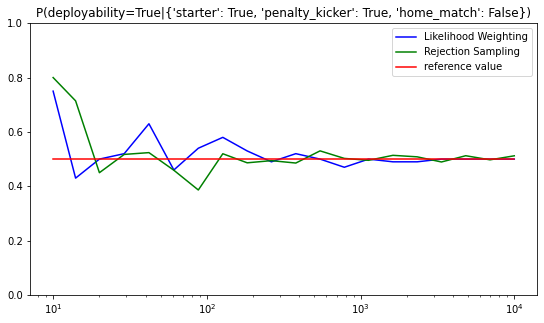

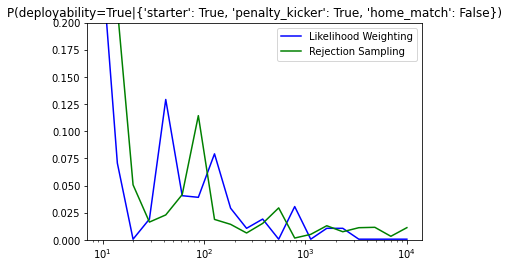

In [ ]:
#P(deployability|starter=True,penalty_kicker=True,home_match=False)
query_var = ['deployability']
query_evidence = {'starter':True,'penalty_kicker':True,'home_match':False}
value=True
approximate_inference(query_var,query_evidence,value)

Eliminating: starter: 100%|██████████| 10/10 [00:00<00:00, 210.45it/s]
/usr/local/lib/python3.7/dist-packages/pgmpy/factors/discrete/DiscreteFactor.py:519: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  "Found unknown state name. Trying to switch to using all state names as state numbers"
Eliminating: starter: 100%|██████████| 10/10 [00:00<00:00, 247.22it/s]


[(   10, 0.6       , 0.07219781, 0.77, 0.24219781)
 (   14, 0.64285714, 0.11505495, 0.38, 0.14780219)
 (   20, 0.6       , 0.07219781, 0.57, 0.04219781)
 (   29, 0.75862069, 0.2308185 , 0.4 , 0.12780219)
 (   42, 0.61904762, 0.09124543, 0.57, 0.04219781)
 (   61, 0.55737705, 0.02957486, 0.51, 0.01780219)
 (   88, 0.47727273, 0.05052947, 0.49, 0.03780219)
 (  127, 0.62204724, 0.09424505, 0.5 , 0.02780219)
 (  183, 0.54098361, 0.01318141, 0.49, 0.03780219)
 (  263, 0.52471483, 0.00308737, 0.47, 0.05780219)
 (  379, 0.55672823, 0.02892604, 0.55, 0.02219781)
 (  545, 0.54862385, 0.02082166, 0.51, 0.01780219)
 (  784, 0.53188776, 0.00408556, 0.44, 0.08780219)
 ( 1128, 0.50443262, 0.02336957, 0.53, 0.00219781)
 ( 1623, 0.53357979, 0.0057776 , 0.52, 0.00780219)
 ( 2335, 0.50920771, 0.01859449, 0.52, 0.00780219)
 ( 3359, 0.53140816, 0.00360596, 0.53, 0.00219781)
 ( 4832, 0.53021523, 0.00241304, 0.52, 0.00780219)
 ( 6951, 0.51733564, 0.01046656, 0.52, 0.00780219)
 (10000, 0.5333    , 0.00549781

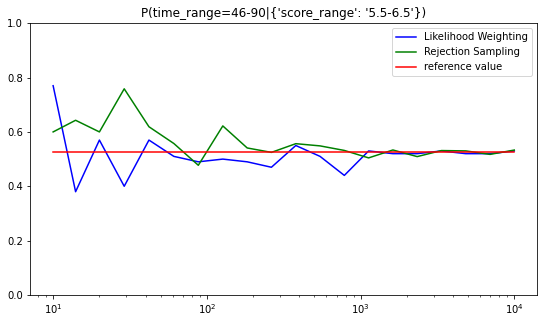

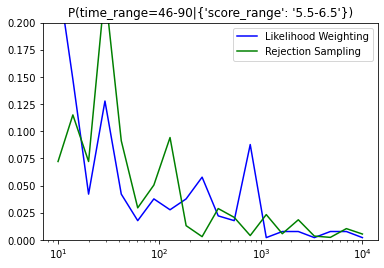

In [ ]:

#P(time_range|score_range='5.5-6.5')
query_var = ['time_range']
query_evidence = {'score_range': '5.5-6.5'}
value='46-90'
approximate_inference(query_var,query_evidence,value)


Eliminating: time_range: 100%|██████████| 10/10 [00:00<00:00, 130.53it/s]
/usr/local/lib/python3.7/dist-packages/pgmpy/factors/discrete/DiscreteFactor.py:519: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  "Found unknown state name. Trying to switch to using all state names as state numbers"
Eliminating: time_range: 100%|██████████| 10/10 [00:00<00:00, 123.72it/s]


[(   10, 0.7       , 0.26406529, 0.43, 0.00593471)
 (   14, 0.5       , 0.06406529, 0.37, 0.06593471)
 (   20, 0.3       , 0.13593471, 0.19, 0.24593471)
 (   29, 0.44827586, 0.01234116, 0.3 , 0.13593471)
 (   42, 0.4047619 , 0.0311728 , 0.41, 0.02593471)
 (   61, 0.36065574, 0.07527897, 0.34, 0.09593471)
 (   88, 0.47727273, 0.04133802, 0.4 , 0.03593471)
 (  127, 0.38582677, 0.05010793, 0.38, 0.05593471)
 (  183, 0.43169399, 0.00424072, 0.4 , 0.03593471)
 (  263, 0.41444867, 0.02148604, 0.35, 0.08593471)
 (  379, 0.4353562 , 0.0005785 , 0.48, 0.04406529)
 (  545, 0.3853211 , 0.0506136 , 0.45, 0.01406529)
 (  784, 0.4375    , 0.00156529, 0.46, 0.02406529)
 ( 1128, 0.42907801, 0.00685669, 0.45, 0.01406529)
 ( 1623, 0.45656192, 0.02062722, 0.43, 0.00593471)
 ( 2335, 0.42226981, 0.0136649 , 0.43, 0.00593471)
 ( 3359, 0.42691277, 0.00902193, 0.43, 0.00593471)
 ( 4832, 0.43977649, 0.00384178, 0.43, 0.00593471)
 ( 6951, 0.43346281, 0.00247189, 0.43, 0.00593471)
 (10000, 0.4379    , 0.00196529

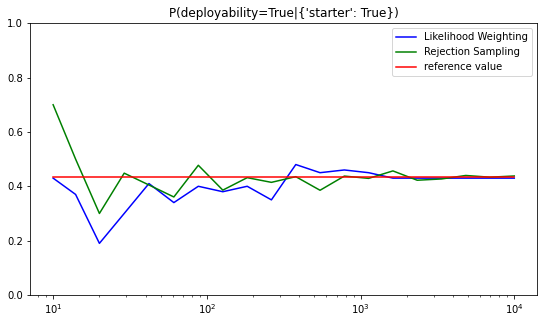

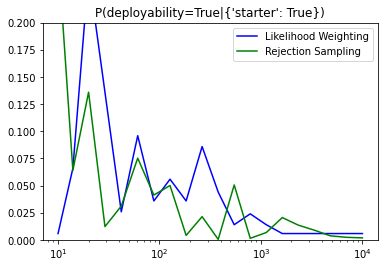

In [ ]:
#P(deployability|starter=True)
query_var = ['deployability']
query_evidence = {'starter': True}
value=True
approximate_inference(query_var,query_evidence,value)

Eliminating: time_range: 100%|██████████| 9/9 [00:00<00:00, 292.50it/s]
/usr/local/lib/python3.7/dist-packages/pgmpy/factors/discrete/DiscreteFactor.py:519: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  "Found unknown state name. Trying to switch to using all state names as state numbers"
Eliminating: time_range: 100%|██████████| 9/9 [00:00<00:00, 275.42it/s]


[(   10, 0.5       , 0.20910098, 0.97, 0.26089902)
 (   14, 0.64285714, 0.06624384, 0.43, 0.27910098)
 (   20, 0.65      , 0.05910098, 0.52, 0.18910098)
 (   29, 0.55172414, 0.15737685, 0.53, 0.17910098)
 (   42, 0.71428571, 0.00518473, 0.63, 0.07910098)
 (   61, 0.6557377 , 0.05336328, 0.66, 0.04910098)
 (   88, 0.63636364, 0.07273735, 0.79, 0.08089902)
 (  127, 0.73228346, 0.02318248, 0.65, 0.05910098)
 (  183, 0.76502732, 0.05592634, 0.79, 0.08089902)
 (  263, 0.7148289 , 0.00572791, 0.74, 0.03089902)
 (  379, 0.7176781 , 0.00857712, 0.73, 0.02089902)
 (  545, 0.70458716, 0.00451383, 0.71, 0.00089902)
 (  784, 0.70153061, 0.00757037, 0.72, 0.01089902)
 ( 1128, 0.69060284, 0.01849815, 0.71, 0.00089902)
 ( 1623, 0.71719039, 0.0080894 , 0.67, 0.03910098)
 ( 2335, 0.71862955, 0.00952857, 0.7 , 0.00910098)
 ( 3359, 0.70735338, 0.0017476 , 0.71, 0.00089902)
 ( 4832, 0.71316225, 0.00406127, 0.69, 0.01910098)
 ( 6951, 0.71184002, 0.00273904, 0.71, 0.00089902)
 (10000, 0.7086    , 0.00050098

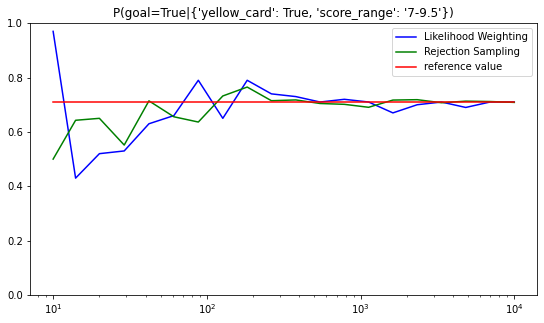

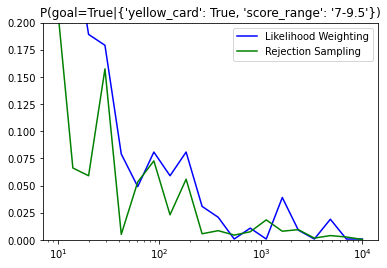

In [ ]:
#P(goal|score_range = 7-9.5,yellow_card=True)"
query_var = ['goal']
query_evidence = {'yellow_card':True,'score_range': '7-9.5'}
value=True
approximate_inference(query_var,query_evidence,value)

Eliminating: starter: 100%|██████████| 10/10 [00:00<00:00, 192.06it/s]
/usr/local/lib/python3.7/dist-packages/pgmpy/factors/discrete/DiscreteFactor.py:519: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  "Found unknown state name. Trying to switch to using all state names as state numbers"
Generating for node: available:   0%|          | 0/12 [00:00<?, ?it/s]       

 P(difficulty_match|goal=True)


Eliminating: starter: 100%|██████████| 10/10 [00:00<00:00, 161.93it/s]


[(   10, 0.2       , 0.07672956, 0.21, 0.06672956)
 (   14, 0.        , 0.27672956, 0.3 , 0.02327044)
 (   20, 0.3       , 0.02327044, 0.37, 0.09327044)
 (   29, 0.24137931, 0.03535025, 0.29, 0.01327044)
 (   42, 0.30952381, 0.03279425, 0.4 , 0.12327044)
 (   61, 0.19672131, 0.08000825, 0.38, 0.10327044)
 (   88, 0.26136364, 0.01536592, 0.31, 0.03327044)
 (  127, 0.23622047, 0.04050909, 0.27, 0.00672956)
 (  183, 0.25136612, 0.02536344, 0.36, 0.08327044)
 (  263, 0.27376426, 0.0029653 , 0.29, 0.01327044)
 (  379, 0.27704485, 0.0003153 , 0.27, 0.00672956)
 (  545, 0.28440367, 0.00767411, 0.26, 0.01672956)
 (  784, 0.29081633, 0.01408677, 0.26, 0.01672956)
 ( 1128, 0.26861702, 0.00811254, 0.29, 0.01327044)
 ( 1623, 0.27233518, 0.00439438, 0.26, 0.01672956)
 ( 2335, 0.27237687, 0.00435269, 0.29, 0.01327044)
 ( 3359, 0.27895207, 0.00222251, 0.28, 0.00327044)
 ( 4832, 0.26821192, 0.00851764, 0.27, 0.00672956)
 ( 6951, 0.27291037, 0.00381919, 0.29, 0.01327044)
 (10000, 0.269     , 0.00772956

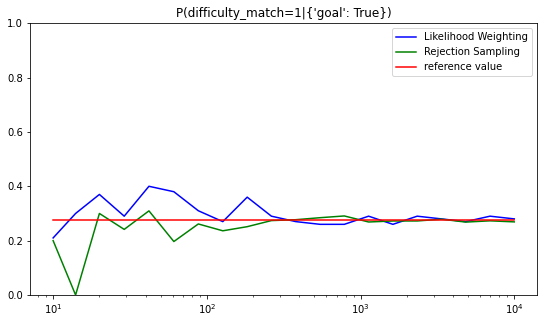

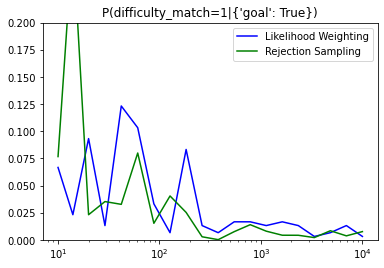

In [ ]:
print(" P(difficulty_match|goal=True)")
query_var = ['difficulty_match']
query_evidence = {'goal':True}
value=1
approximate_inference(query_var,query_evidence,value)